In [1]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering
import numpy as np
from py2neo import Graph, Node
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium


In [2]:
graph = Graph("neo4j+s://f3c31cc9.databases.neo4j.io", auth=("neo4j", "4vXe5nxy_YDRFV33WjNh99OJRVU71z-5BSLOGv5t-P8")) 

In [4]:
# Step 2: Retrieve Crime Data from Neo4j AuraDB
query = """
MATCH (c:crimes)-[:OCCURRED_AT]->(l:location)-[:LAT_LOC]->(lat:latitude)
MATCH (l)-[:LONG_LOC]->(long:longitude)
RETURN c.case_number AS case_number, 
       lat.latitude AS latitude, 
       long.longitude AS longitude,
       l.location AS location,
       c.date_occurred AS date_occurred,
       c.date_reported AS date_reported,
       c.crime_description AS crime_description,
       c.victim_age AS victim_age,
       c.crime_code AS crime_code
"""
result = graph.run(query)
crime_data = pd.DataFrame(result, columns=result.keys())
a = crime_data.head()
print(a)

   case_number  latitude  longitude                                  location  \
0            1   34.2012  -118.4444   7200    TYRONE                       AV   
1          190   34.2012  -118.5445  19200    SHERMAN                      WY   
2         1527   34.2012  -118.5445  19200    SHERMAN                      WY   
3          316   34.2012  -118.4444           SHERMAN                      WY   
4          957   34.2012  -118.4444           SHERMAN                      WY   

      date_occurred date_reported  \
0  01-07-2020 08:00    02-12-2023   
1  01-12-2023 19:00    02-12-2023   
2  02-12-2023 06:00    04-12-2023   
3  02-12-2023 09:00    02-12-2023   
4  04-12-2023 16:40    04-12-2023   

                                 crime_description  victim_age  crime_code  
0                 DOCUMENT FORGERY / STOLEN FELONY          64         649  
1                                 VEHICLE - STOLEN           0         510  
2                                THEFT OF IDENTITY         

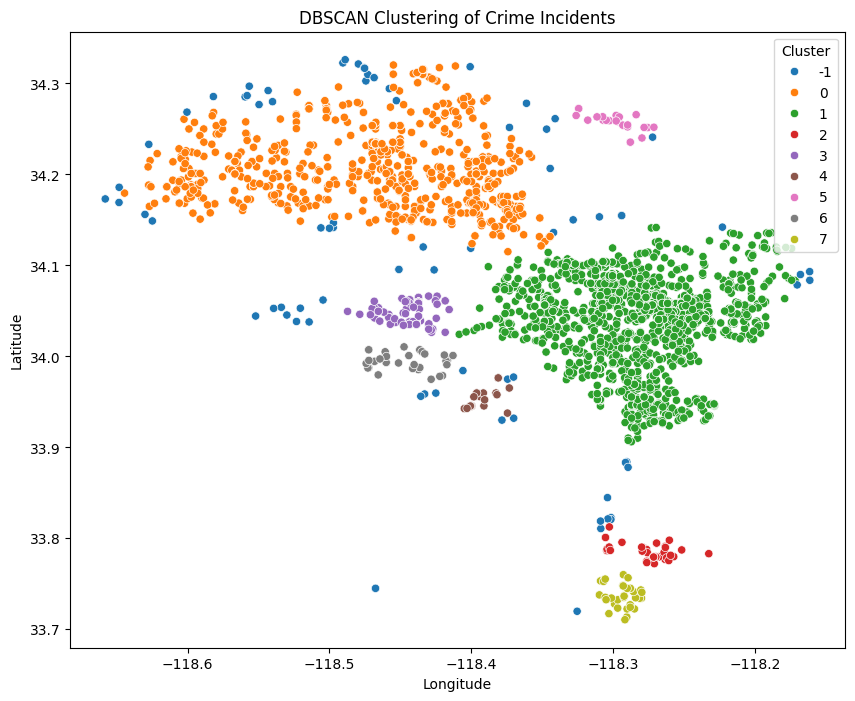

In [5]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define DBSCAN parameters
eps = 0.02  # Maximum distance between two samples to be considered as part of the same neighborhood
min_samples = 15  # Minimum number of samples in a neighborhood for a point to be considered as a core point

# Step 2: Initialize DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# Step 3: Fit DBSCAN to crime data and predict clusters
crime_data['dbscan_cluster'] = dbscan.fit_predict(crime_data[['latitude', 'longitude']])

# Step 4: Visualize clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='longitude', y='latitude', hue='dbscan_cluster', palette='tab10', data=crime_data)
plt.title('DBSCAN Clustering of Crime Incidents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster', loc='upper right')
plt.show()

In [8]:
# Step 4: Hierarchical Clustering
hierarchical_clusterer = AgglomerativeClustering(n_clusters=5, linkage='ward')
crime_data['hierarchical_cluster'] = hierarchical_clusterer.fit_predict(crime_data[['latitude', 'longitude']])

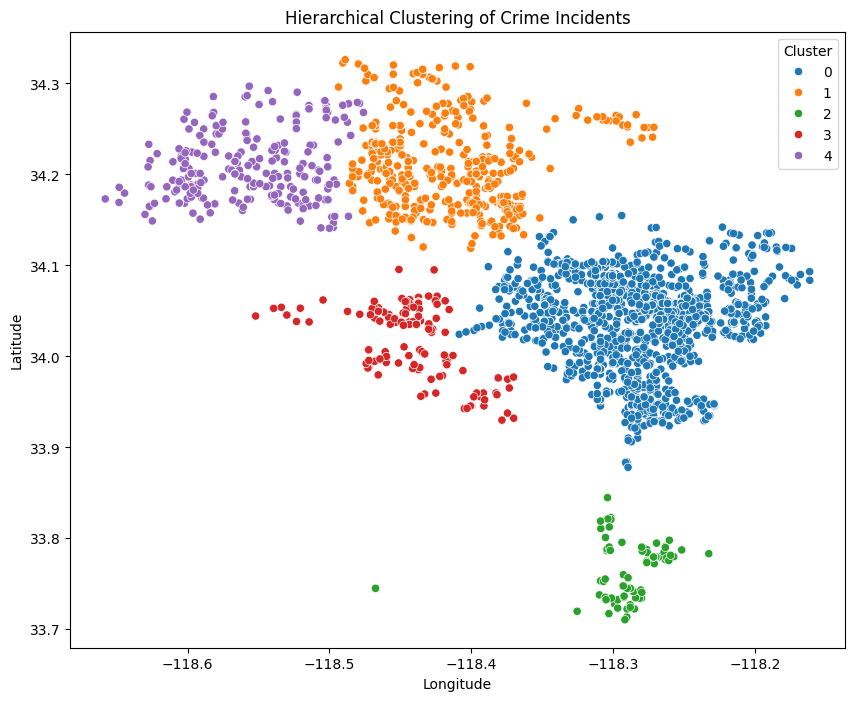

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot clusters on a map using latitude and longitude coordinates
plt.figure(figsize=(10, 8))
sns.scatterplot(x='longitude', y='latitude', hue='hierarchical_cluster', palette='tab10', data=crime_data)
plt.title('Hierarchical Clustering of Crime Incidents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster', loc='upper right')
plt.show()


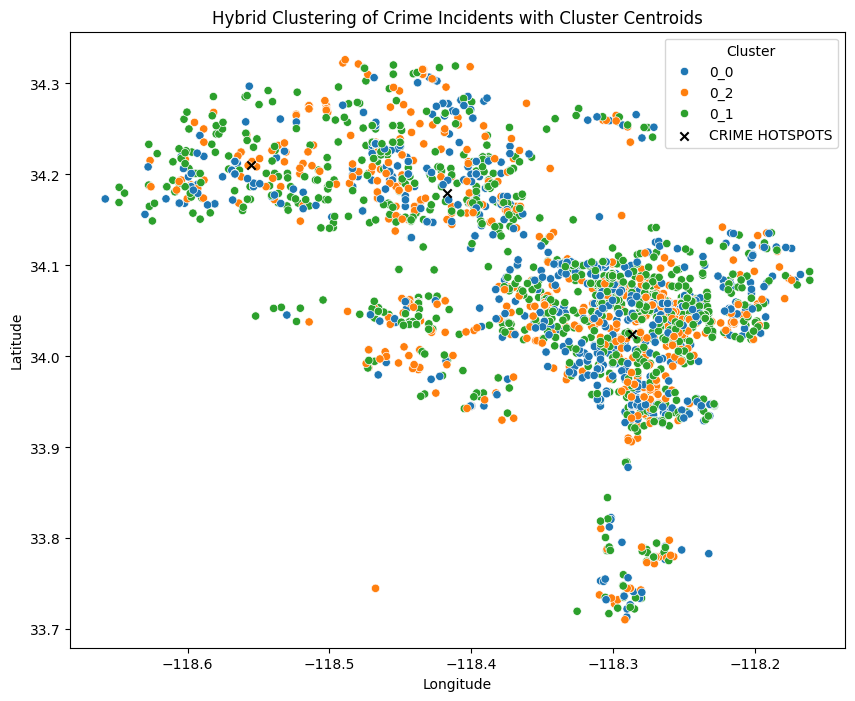

In [10]:
from sklearn.cluster import KMeans

# Step 1: DBSCAN Clustering
dbscan = DBSCAN(eps=1, min_samples=5)
crime_data['dbscan_cluster'] = dbscan.fit_predict(crime_data[['latitude', 'longitude']])

# Step 2: Calculate multiple centroids for each DBSCAN cluster using KMeans
cluster_centroids = []
for cluster_label in np.unique(crime_data['dbscan_cluster']):
    if cluster_label == -1:  # Skip noise points
        continue
    cluster_points = crime_data[crime_data['dbscan_cluster'] == cluster_label][['latitude', 'longitude']]
    kmeans = KMeans(n_clusters=3, random_state=0)  # Adjust the number of centroids as needed
    kmeans.fit(cluster_points)
    centroids = kmeans.cluster_centers_
    cluster_centroids.extend(centroids)

# Convert centroids to a DataFrame
centroids_df = pd.DataFrame(cluster_centroids, columns=['latitude', 'longitude'])

# Step 3: Hierarchical Clustering
hierarchical_clusterer = AgglomerativeClustering(n_clusters=3, linkage='ward')
crime_data['hierarchical_cluster'] = hierarchical_clusterer.fit_predict(crime_data[['victim_age', 'crime_code']])

# Combine the results of DBSCAN and hierarchical clustering
# For simplicity, we'll assign a new cluster label for each combination of DBSCAN and hierarchical clusters
crime_data['hybrid_cluster'] = crime_data['dbscan_cluster'].astype(str) + '_' + crime_data['hierarchical_cluster'].astype(str)

# Step 4: Visualization with centroids
plt.figure(figsize=(10, 8))
sns.scatterplot(x='longitude', y='latitude', hue='hybrid_cluster', palette='tab10', data=crime_data)
plt.scatter(centroids_df['longitude'], centroids_df['latitude'], color='black', marker='x', label='CRIME HOTSPOTS')
plt.title('Hybrid Clustering of Crime Incidents with Cluster Centroids')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster', loc='upper right')
plt.show()


In [11]:
import folium

# Create a map centered at the mean latitude and longitude
mean_latitude = centroids_df['latitude'].mean()
mean_longitude = centroids_df['longitude'].mean()
crime_map = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=12)

# Add markers for each crime incident, color-coded by cluster
for index, row in crime_data.iterrows():
    popup_content = f"Latitude: {row['latitude']}\n"
    popup_content += f"Longitude: {row['longitude']}\n"
    popup_content += f"Date Occurred: {row['date_occurred']}\n"
    popup_content += f"Date Reported: {row['date_reported']}\n"
    popup_content += f"Crime Description: {row['crime_description']}\n"
    popup_content += f"Hybrid Cluster: {row['hybrid_cluster']}\n"

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='blue' if row['hybrid_cluster'] == -1 else 'RED',  # Use blue for outliers
        fill=True,
        fill_color='blue' if row['hybrid_cluster'] == -1 else 'pink',
        fill_opacity=0.6,
        popup=popup_content
    ).add_to(crime_map)

# Add markers for cluster centroids
for index, centroid in centroids_df.iterrows():
    folium.Marker(
        location=[centroid['latitude'], centroid['longitude']],
        icon=folium.Icon(color='black', icon='info-sign'),
        popup=f"Crime hotspot {index+1}"
    ).add_to(crime_map)

# Display the map
crime_map
